In [1]:
# Automatic reload of modules
%load_ext autoreload
%autoreload 2

import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from scipy import signal

import utils

# 1. Tutorial

### 1.1 Define Z-transform through numerator/denominator (b/a) coefficients

Lets get a sense of some useful Python functions as well as helper functions in this homework. <br>
Executing the code below will plot the poles and zeros of the following Z-transform: <br>
### $ H(z)=\frac{z^{-1}+z^{-2}}{1+\frac{1}{4}z^{-1}-\frac{3}{8}z^{-2}}$

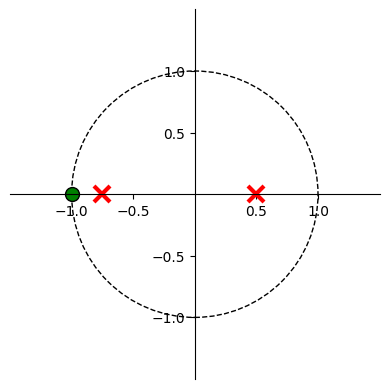

(array([-1.+0.j]), array([-0.75+0.j,  0.5 +0.j]), 1.0)

In [2]:
b = np.array([0, 1, 1], dtype=np.complex128)
a = np.array([1, 1/4., -3/8.], dtype=np.complex128)
utils.zplane_ba(b,a)

As you can see, the way we tell the function the structure of the Z-transform is by putting the coefficients of the polynomials into 2 lists. List $b$ contains the numerator coefficients and list $a$ contains the denominator coefficients.

### 1.2 Defining Z-transform with poles/zeros

Alternatively, we can specify the same Z-transform by poles and zeros.

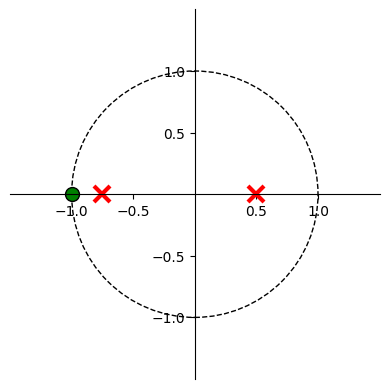

In [3]:
zeros = np.array([-1], dtype=np.complex128)
poles = np.array([-0.75, 0.50], dtype=np.complex128)
utils.zplane_zp(zeros, poles)

One can either define the Z-transform with the pole/zero or the b/a definition and get similar results.

### 1.3 Impulse response of the Z-transform

In [4]:
fs = 30 # Hz
dt = 1/fs
k = 1 # Gain

t, y = signal.dimpulse((zeros, poles, k, dt), n=32)
y = np.squeeze(y)

Text(0.5, 1.0, 'Impulse Response')

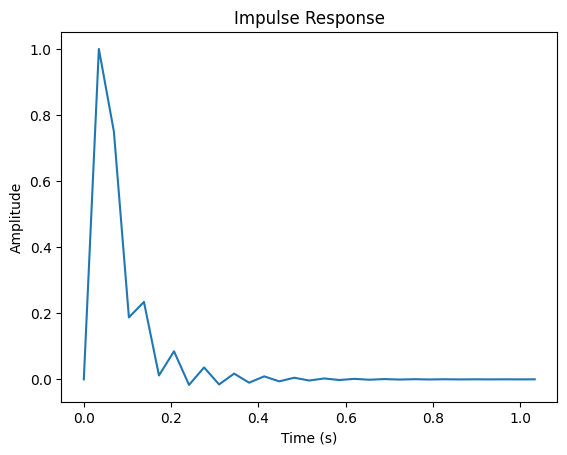

In [5]:
plt.plot(t, y)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Impulse Response")

### 1.4 Frequency Domain Analysis of Transfer Function 

Text(0.5, 1.0, 'Phase Response')

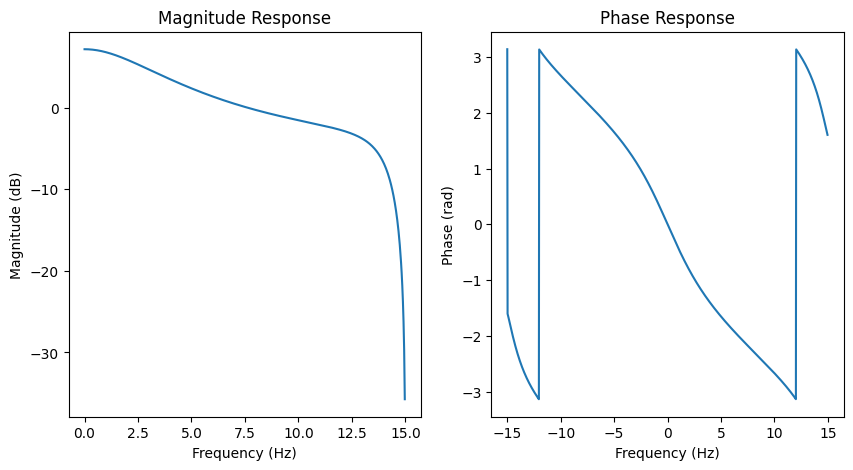

In [6]:
yF = np.fft.fft(y, n=1024)
yF = np.fft.fftshift(yF)
yF_mag = 20*np.log10(np.abs(yF))
yF_ang = np.angle(yF)

freq = np.fft.fftfreq(len(yF), dt)
freq = np.fft.fftshift(freq)

# 1x2 Plot of Magnitude and Phase
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(freq[len(freq)//2:], yF_mag[len(freq)//2:])
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Magnitude (dB)")
ax1.set_title("Magnitude Response")
ax2.plot(freq, (yF_ang))
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("Phase (rad)")
ax2.set_title("Phase Response")

Now putting everything together, with one function, we can plot the impulse response, pole-zero plot, as well as the magnitude and phase response!

c:\Users\User\EE113 Hw7\utils.py:139: RuntimeWarning: divide by zero encountered in log10
  yF_mag = 20*np.log10(np.abs(yF))


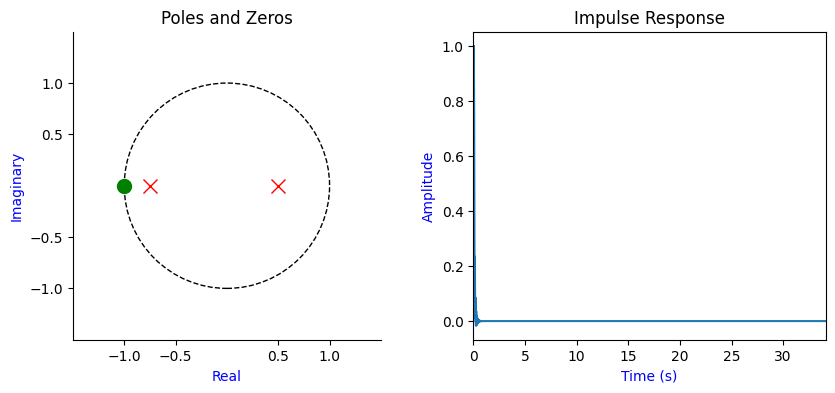

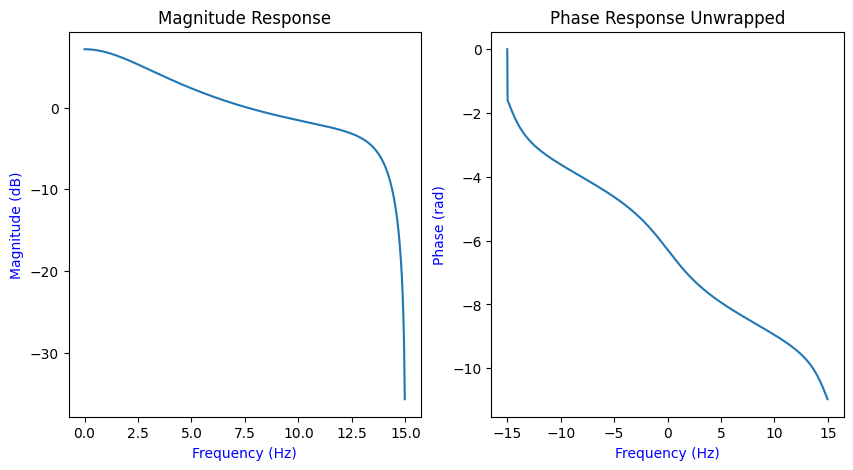

In [7]:
utils.freq_analysis(poles, zeros, k, fs, n=1024)

<b>*Question 1: What kind of a filter is this, based of the Magnitude Response (low-pass, high-pass, band-pass)?</b>* <br>
Answer: [It's a low pass filter]

<b>*Question 2: How can you tell what kind of a filter this is from the pole-zero plots?</b>* <br>
Answer: [Our testing point moves counterclockwise along the circle as frequency increases. We'll notice that the distance to the two poles remain relatively constant but the distance to the zero point gets smaller as we move along the circle, which indicates that the frequency response would decrease as frequency increases. Thus, it is a LPF.]

### 1.5 Adding a gain term to the pole-zero definition 

Often, we want to control the maximum gain of our system. In this case we want the DC response to be unity. 

Hint: We want to find the gain $k$ that will make the below equation true. <br>
### $ k\cdot H(e^{j0})=1$
Try solving for the required gain with pen and paper. <br>
After adding the gain, your transfer function will become:
### $ G(z)=k\frac{z^{-1}+z^{-2}}{1+\frac{1}{4}z^{-1}-\frac{3}{8}z^{-2}}$

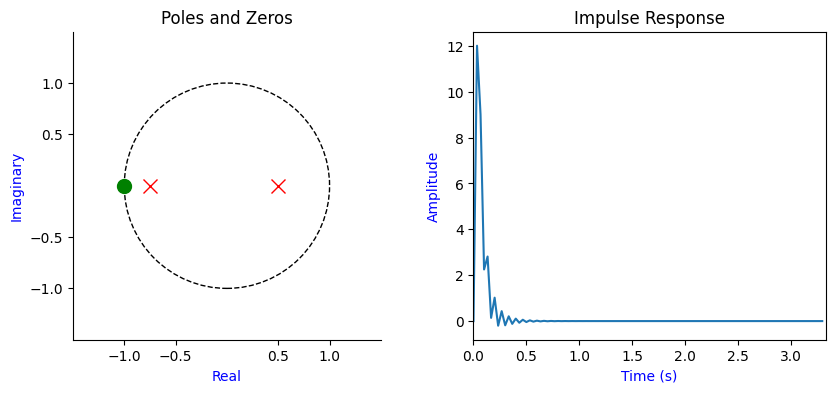

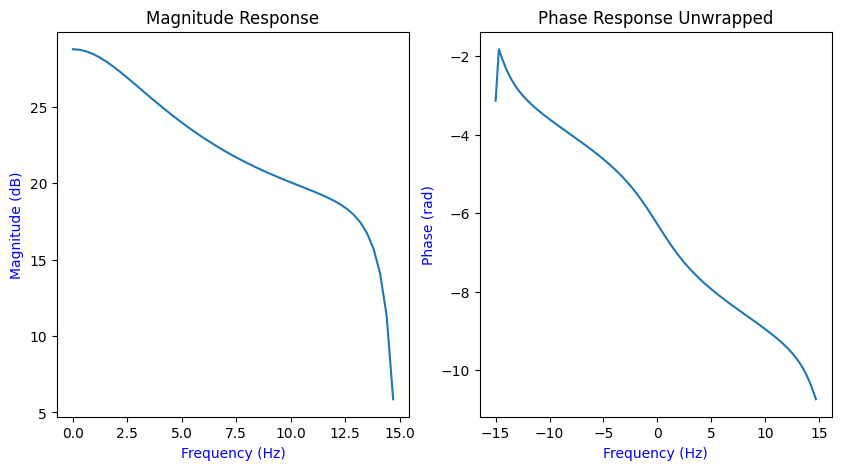

In [8]:
# Change the gain term below to see how it affects the magnitude response

########## Change Gain Here ##########
k = 12
######################################
utils.freq_analysis(poles, zeros, k, fs, n=100)

<b>*Question 3: Describe the changes or lack of changes that occured in each plot as the gain changed from k=1 to the new gain value that you found. Also note down the gain value that you found. </b>* <br>
Answer: [I changed the gain from k=1 to k=12. This would only change the Magnitude Response and the Impulse Response. The maximum amplitude of IR would change depending on the gain (it would be equivalent to the k-value), and the low frequency magnitude for the Magnitude Response would change due to the gain.]

# 2. Filtering an EKG Signal

![title](data/pwave.gif) <br>

Electrocardiography is the process of producing an electrocardiogram (ECG or EKG), a recording of the heart's electrical activity through repeated cardiac cycles. It is an electrogram of the heart which is a graph of voltage versus time of the electrical activity of the heart using electrodes placed on the skin. These electrodes detect the small electrical changes that are a consequence of cardiac muscle depolarization followed by repolarization during each cardiac cycle (heartbeat). Changes in the normal ECG pattern occur in numerous cardiac abnormalities, including cardiac rhythm disturbances such as atrial fibrillation and ventricular tachycardia. - [Wikipedia](https://en.wikipedia.org/wiki/Electrocardiography)

Due to the relatively low signal strength of the EKG, various noise sources can easily contaminate the recorded EKG signal. In the following code blocks, we will explore one of these noise sources and try to remove it with filter designed through the $Z$-transform. 

Our goal is to try to make the signal as clean as possible so that if a medical professional were to look at it, they can clearly make out the QRS complex and the P/T waves that are drawn in their idealized form in the picure above. 

### 2.1 Data Analysis

Here you are provided with a sample EKG recording. One sample is relatively clean, while the other is contaminated with noise. <br>
Important notes:
1. The EKG data provided is sampled at 1024 Hz
2. The data is in units of milli-volts (mV). 
3. The EKG has most of its frequency content between 0-100 Hz.

In [9]:
fs = 1024 # Hz # 1 EKG sample every 1/fs seconds
dt = 1/fs
M = 9000 # Number of samples
t = np.arange(0, M*dt, dt)

Text(0.5, 1.0, 'Normal EKG')

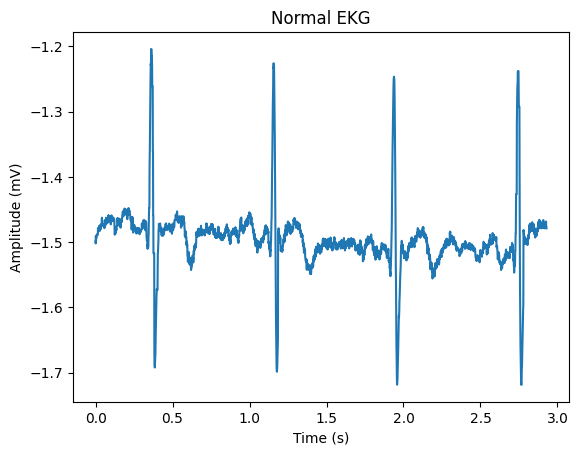

In [10]:
normal_ekg = np.load("./data/normal_ekg.npy", allow_pickle=True)[0:M//3]
t = np.arange(0, len(normal_ekg)*dt, dt)
plt.plot(t, normal_ekg)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.title("Normal EKG")

Text(0.5, 1.0, 'Noisy EKG')

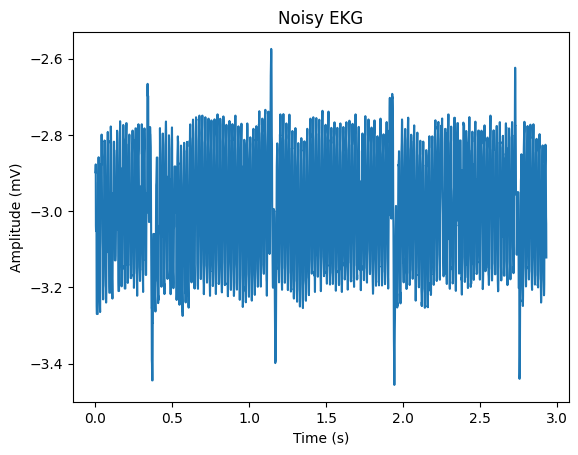

In [17]:
noisy_ekg = np.load("./data/noisy_ekg.npy", allow_pickle=True)[0:M//3]
plt.plot(t, noisy_ekg)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.title("Noisy EKG")

In the next section we will try to find the source of the noise.

Text(0.5, 1.0, 'Magnitude Response')

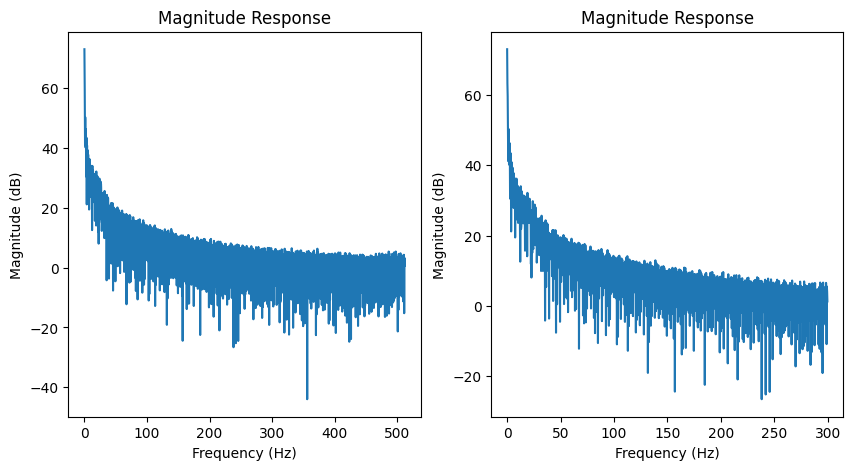

In [18]:
# Analyze the normal EKG in the frequency domain
########## Add code here to analyze the normal EKG signal in the Frequency domain ##########
# Try creating two plots - one with the full frequency range and one zoomed in on 0-300 Hz #
N = 4*1024
EKG_w = np.fft.fft(normal_ekg, n=N)
EKG_w = np.fft.fftshift(EKG_w)
EKG_mag = 20*np.log10(np.abs(EKG_w))
EKG_ang = np.angle(EKG_w)

freq = np.fft.fftfreq(len(EKG_w), dt)
freq = np.fft.fftshift(freq)

# 1x2 Plot of Magnitude and Phase
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(freq[len(freq)//2:], EKG_mag[len(freq)//2:])
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Magnitude (dB)")
ax1.set_title("Magnitude Response")

ax2.plot(freq[len(freq)//2:(len(freq)//2+300*(N//fs))], EKG_mag[len(freq)//2:(len(freq)//2+300*(N//fs))])
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("Magnitude (dB)")
ax2.set_title("Magnitude Response")

######################################


### 2.2 Frequency Analysis 

Text(0.5, 1.0, 'Magnitude Response')

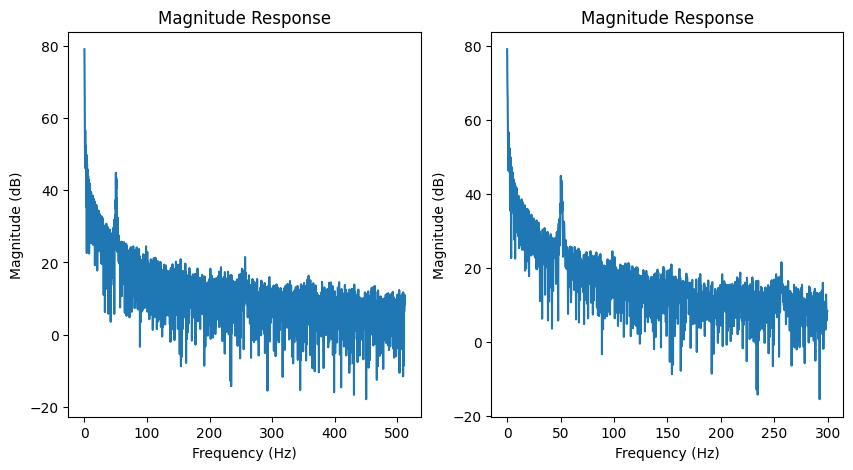

In [19]:
# Analyze the NOISY EKG in the frequency domain
########## Add code here to analyze the NOISY EKG signal in the Frequency domain ##########
# Try creating two plots - one with the full frequency range and one zoomed in on 0-300 Hz #

N = 4*1024
EKG_w_noisy = np.fft.fft(noisy_ekg, n=N)
EKG_w_noisy = np.fft.fftshift(EKG_w_noisy)
EKG_mag_noisy = 20*np.log10(np.abs(EKG_w_noisy))
EKG_ang_noisy = np.angle(EKG_w_noisy)

freq_noisy = np.fft.fftfreq(len(EKG_w_noisy), dt)
freq_noisy = np.fft.fftshift(freq_noisy)

# 1x2 Plot of Magnitude and Phase
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(freq_noisy[len(freq_noisy)//2:], EKG_mag_noisy[len(freq_noisy)//2:])
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Magnitude (dB)")
ax1.set_title("Magnitude Response")

ax2.plot(freq_noisy[len(freq_noisy)//2:(len(freq_noisy)//2+300*(N//fs))], EKG_mag_noisy[len(freq_noisy)//2:(len(freq_noisy)//2+300*(N//fs))])
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("Magnitude (dB)")
ax2.set_title("Magnitude Response")

######################################

<b>*Question 4: You should be able to see that there is an interesting difference between the magnitude spectrum of the normal and noisy EKG. <br>
Note down your observations and see how they may relate to an electrical interference effect that can be read about at the following [link](https://en.wikipedia.org/wiki/Mains_hum).</b>* <br>
Answer: [There exists a huge peak in the Magnitude Response that is around 50Hz. This noise source looks like a main hum, whose fundamental is around 50-60 Hz.]

<b>*Question 5: What frequency does the noise occur at?* </b> <br>
Answer:[The $f_0$ for the noise occurs around 50Hz. The harmonics would occur at the multiple of 50Hz ]

### 2.3 Fixing the Noisy EKG signal

There are two problems that we are going to try to fix using what we learned in the Z-transform. <br>
1. There is a strong noise component at some frequency due to EM interference that we will try to eliminate with a notch filter.
2. The noise component may have harmonics that cause noise as well.

### 2.3.1 FIR Notch Filter
Let's start by just adding zeros to the locations in the spectrum, $\omega_o$, where we want to remove noise.

### $k\frac{(z-e^{j\omega_o})(z-e^{-j\omega_o})}{z^2}$

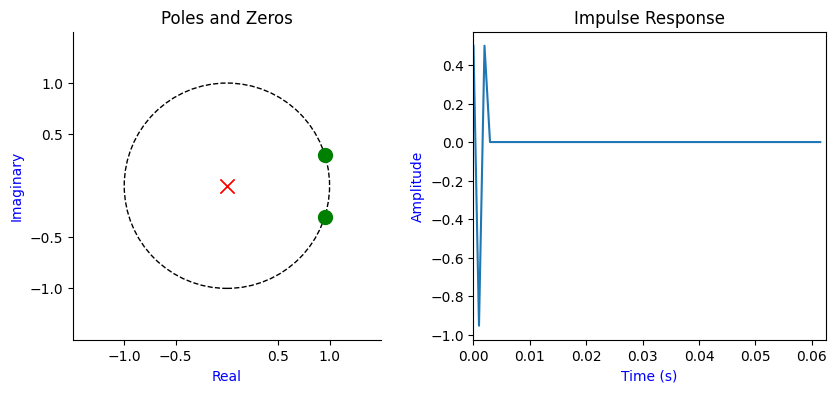

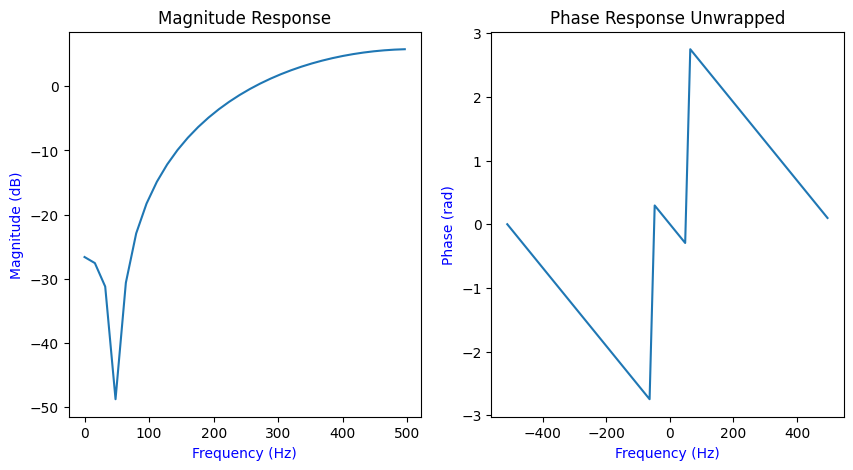

In [20]:
########## Add your definition of the filter coefficients here ##########
from math import pi

f0 = 50
F0 = f0/fs
zeros = np.array([np.exp(2j*pi*F0), np.exp(-2j*pi*F0)], dtype=np.complex128)
poles = np.array([0, 0], dtype=np.complex128)
k = 0.5
#########################################################################
utils.freq_analysis(poles, zeros, k, fs, n=64)

Let's see how your filter did on the sample data! 
1. We will convert the poles, zeros, and gain (k) to numerator/denominator coefficients stored in the variables $b$ and $a$. 
2. We will then give the filter coefficients and the noisy EKG signal we want to filter to the function *signal.filtfilt*. 
3. This function will filter the input signal with your designed filter and return the filtered signal as output. 

Important note! Read the function description of [filtfilt](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html). You'll find that its implementation is not real-time since it first forward filters and then backward filters the signal. This will have the effect of doubling the filter order and making our filter have the special property of having zero phase. This means that the application of the filters is done in such a way that the resulting phase of the output signal has no group delay. You can read more about this [here](https://www.dsprelated.com/freebooks/filters/Phase_Group_Delay.html) if you are curious. 

In [21]:
b, a = signal.zpk2tf(zeros, poles, k)
filtered_ekg = signal.filtfilt(b, a, x=noisy_ekg)

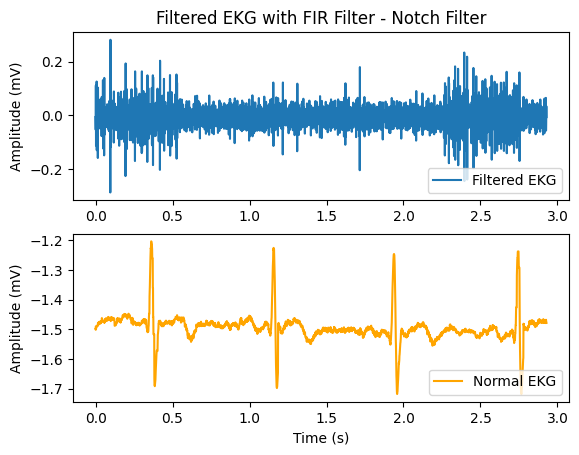

In [22]:
b, a = signal.zpk2tf(zeros, poles, k)
filtered_ekg = signal.filtfilt(b, a, x=noisy_ekg)
filtered_ekg = [np.real(x) for x in filtered_ekg]

t = np.arange(0, M//3*dt, dt)
# 2 plots stacked 
plt.figure()
plt.subplot(2,1,1)
plt.plot(t, filtered_ekg[0:M//3], label="Filtered EKG")
plt.title("Filtered EKG with FIR Filter - Notch Filter")
plt.ylabel("Amplitude (mV)")
plt.legend(loc='lower right')

plt.subplot(2,1,2)
plt.plot(t, normal_ekg[0:M//3], color="orange", label="Normal EKG")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.legend(loc='lower right')

Text(0.5, 1.0, 'Magnitude Response')

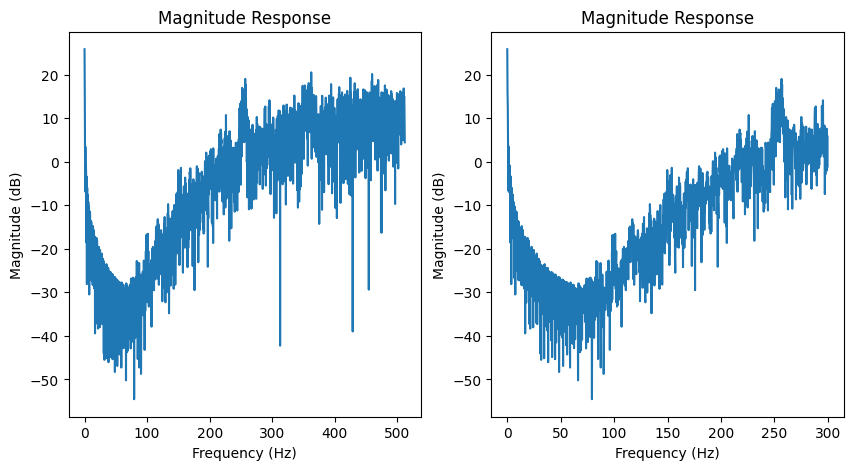

In [23]:
# Analyze the Filtered EKG in the frequency domain
########## Add code here to analyze the Filtered EKG signal in the Frequency domain ##########
# Try creating two plots - one with the full frequency range and one zoomed in on 0-300 Hz #

N = 4*1024
EKG_w_filt = np.fft.fft(filtered_ekg, n=N)
EKG_w_filt = np.fft.fftshift(EKG_w_filt)
EKG_mag_filt = 20*np.log10(np.abs(EKG_w_filt))
EKG_ang_filt = np.angle(EKG_w_filt)

freq_filt = np.fft.fftfreq(len(EKG_w_filt), dt)
freq_filt = np.fft.fftshift(freq_filt)

# 1x2 Plot of Magnitude and Phase
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(freq_filt[len(freq_filt)//2:], EKG_mag_filt[len(freq_filt)//2:])
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Magnitude (dB)")
ax1.set_title("Magnitude Response")

ax2.plot(freq_filt[len(freq_filt)//2:(len(freq_filt)//2+300*(N//fs))], EKG_mag_filt[len(freq_filt)//2:(len(freq_filt)//2+300*(N//fs))])
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("Magnitude (dB)")
ax2.set_title("Magnitude Response")

######################################

If you implemented it correctly, the Filtered EKG will look different but not correct. 

<b>*Question 6: Did the filter do its job of removing the noise? Are there any unwanted side-effects of this filter? If yes, explain.</b>* <br>
Answer: [It does remove the 50Hz noise. However, high frequencies got amplified. We don't want to change the response for the high frequencies. ]

### 2.3.2 IIR Notch Filter

You may have noticed that the previous filter added a higher gain to the higher frequencies than the lower frequences (where most of the EKG signal is) due to the placement of the zeros. We can remedy this by placing poles close to the locations of the zeros. 

### $k\frac{(z-e^{j\omega_o})(z-e^{-j\omega_o})}{(z-\alpha e^{j\omega_o})(z-\alpha e^{-j\omega_o})},  \quad |\alpha|<1$

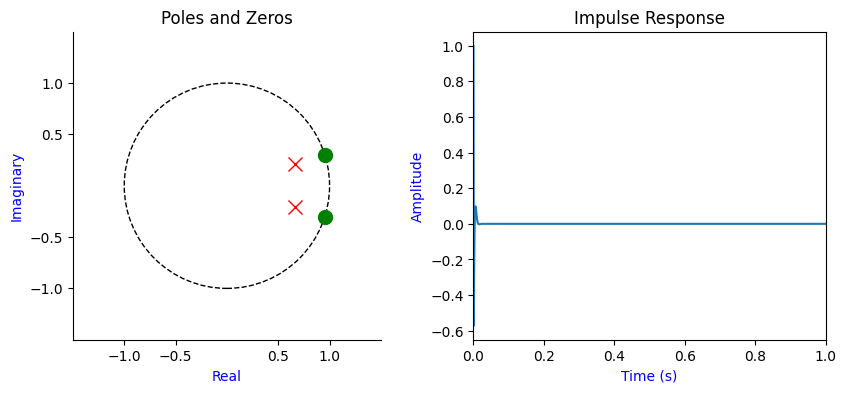

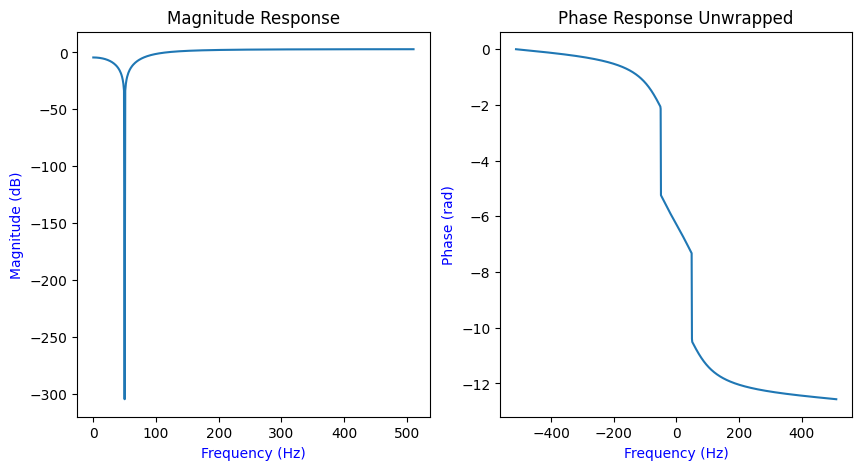

In [24]:
########## Add your definition of the filter coefficients here ##########
f0 = 50
F0 = f0/fs
a = 0.7
zeros = np.array([np.exp(2j*pi*F0), np.exp(-2j*pi*F0)], dtype=np.complex128)
poles = np.array([a*np.exp(2j*pi*F0), a*np.exp(-2j*pi*F0)], dtype=np.complex128)
k = 1
#########################################################################
utils.freq_analysis(poles, zeros, k, fs, n=1024)

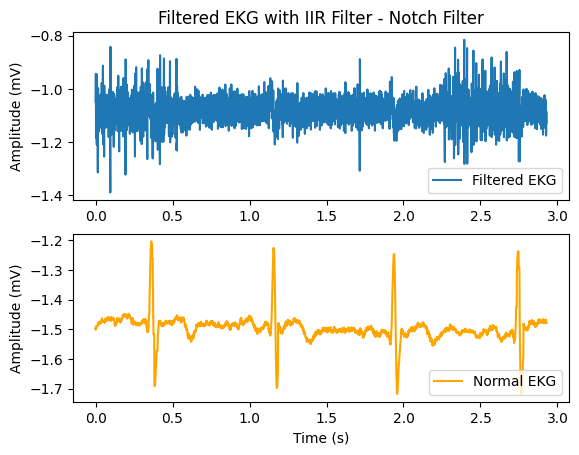

In [25]:
b, a = signal.zpk2tf(zeros, poles, k)
filtered_ekg = signal.filtfilt(b, a, x=noisy_ekg)
filtered_ekg = [np.real(x) for x in filtered_ekg]

t = np.arange(0, M//3*dt, dt)
# 2 plots stacked 
plt.figure()
plt.subplot(2,1,1)
plt.plot(t, filtered_ekg[0:M//3], label="Filtered EKG")
plt.title("Filtered EKG with IIR Filter - Notch Filter")
plt.ylabel("Amplitude (mV)")
plt.legend(loc='lower right')

plt.subplot(2,1,2)
plt.plot(t, normal_ekg[0:M//3], color="orange", label="Normal EKG")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.legend(loc='lower right')

Text(0.5, 1.0, 'Magnitude Response')

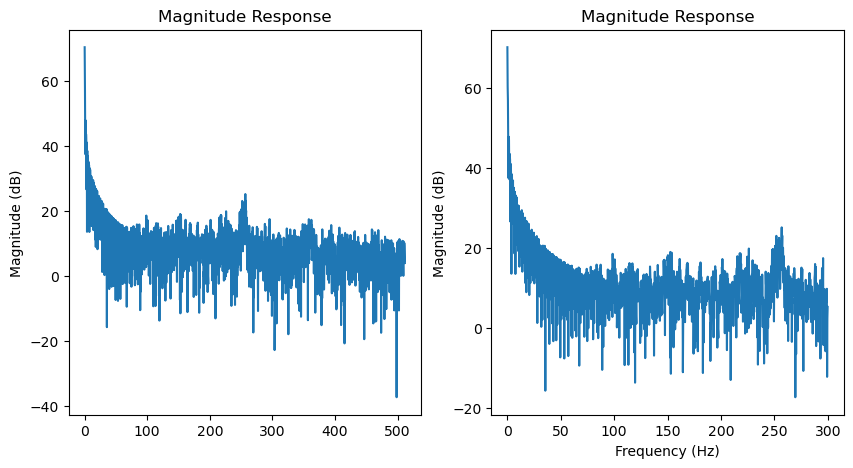

In [20]:
# Analyze the Filtered EKG in the frequency domain
########## Add code here to analyze the Filtered EKG signal in the Frequency domain ##########
# Try creating two plots - one with the full frequency range and one zoomed in on 0-300 Hz #

N = 4*1024
EKG_w_filt = np.fft.fft(filtered_ekg, n=N)
EKG_w_filt = np.fft.fftshift(EKG_w_filt)
EKG_mag_filt = 20*np.log10(np.abs(EKG_w_filt))
EKG_ang_filt = np.angle(EKG_w_filt)

freq_filt = np.fft.fftfreq(len(EKG_w_filt), dt)
freq_filt = np.fft.fftshift(freq_filt)

# 1x2 Plot of Magnitude and Phase
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(freq_filt[len(freq_filt)//2:], EKG_mag_filt[len(freq_filt)//2:])
#ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Magnitude (dB)")
ax1.set_title("Magnitude Response")

ax2.plot(freq_filt[len(freq_filt)//2:(len(freq_filt)//2+300*(N//fs))], EKG_mag_filt[len(freq_filt)//2:(len(freq_filt)//2+300*(N//fs))])
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("Magnitude (dB)")
ax2.set_title("Magnitude Response")


######################################

<b>*Question 7: Vary the value of $\alpha$ and observe the resulting signal and Magnitude in the Frequency domain. How does $\alpha$ affect the resulting signal when it is very close 1, between 0 and 1, and very close to 0?</b>* <br>
Answer: [if $\alpha$ is close to 0, that is no different from a FIR Notch filter where we have two poles at $z=0$. The high frequency components will still be boosted. Setting $\alpha$ closer to 1 trims down the high frequency components. That's because the distance to the poles and zeros will be almost the same if we have poles and zeros close to each other, thus it would only attenuate 50Hz without affecting the response of the rest of the frequencies. However, if we set $\alpha$ very close to 1 ($\alpha=0.999$), the bandwidth for the filter will be too narrow to attenuate the 50Hz noise, thus it's ideal to set $\alpha=0.7$. It is close to 1 but not extremely close to 1.]

Let your answer to Question 7 guide how you chose the parameter $\alpha$ for the rest of the assignment.

### 2.3.3 IIR Notch Filter with Harmonics

Now, the previous filter has solved the problem of the higher gain at higher frequencies with the pole-zero like cancellation method. But, the filtered signal still looks very noisy. If you do a closer analysis of the frequency spectrum, you will find harmonics of 50 Hz that contribute to the noise. Now we need to add $N$ number notches corresponding to the number of harmonics visible.

### $k\frac{\prod^{N}_{m=1} (z-e^{jm\omega_o})(z-e^{-jm\omega_o})}{\prod^{N}_{m=1}(z-\alpha e^{jm\omega_o})(z-\alpha e^{-jm\omega_o})},  \quad |\alpha|<1$

<b>*Question 8: Use of your previous code blocks to analyze where harmonics of the noise may occur. What frequencies do you see harmonics at and what value of $N$ should you chose to remove the harmonic noise?*</b><br>
Answer: [I chose N=9 since our frequency spectrum goes from 0-499Hz. I want to eliminate the main hum and its harmonics that occur every 50Hz ranging from 50Hz to 450Hz.]

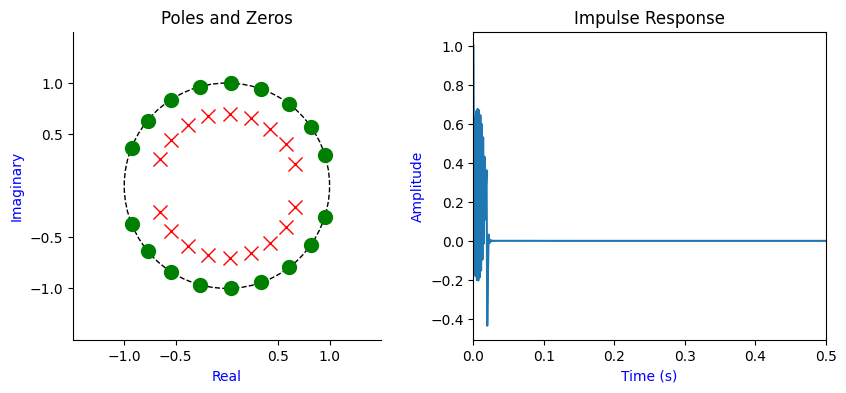

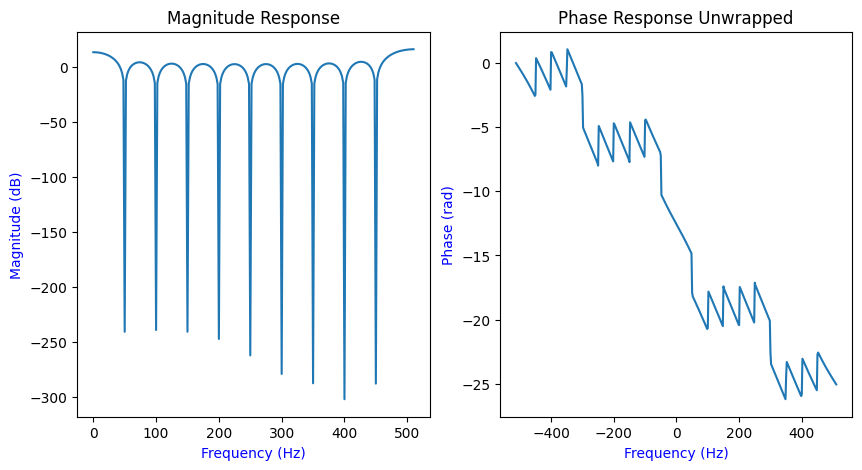

In [26]:
zeros_list = []
poles_list = []
a = 0.7

for i in range(9):
    f0 = 50*(i+1)
    F0 = f0/fs
    zeros_list.append(np.exp(2j*pi*F0))
    zeros_list.append(np.exp(-2j*pi*F0))
    poles_list.append(a*np.exp(2j*pi*F0))
    poles_list.append(a*np.exp(-2j*pi*F0))

zeros = np.array(zeros_list, dtype=np.complex128)
poles = np.array(poles_list, dtype=np.complex128)
k = 1
#########################################################################
utils.freq_analysis(poles, zeros, k, fs, n=512)

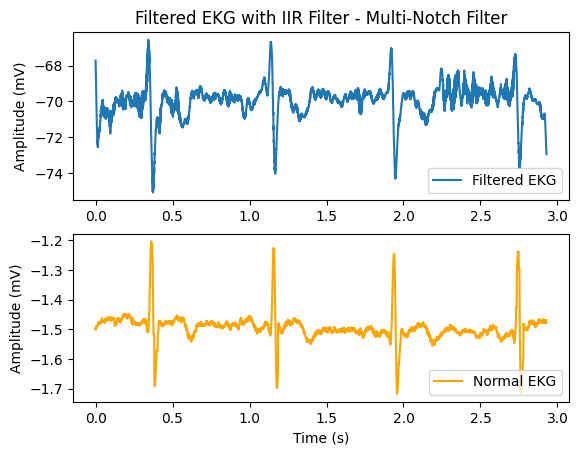

In [27]:
b, a = signal.zpk2tf(zeros, poles, k)
filtered_ekg = signal.filtfilt(b, a, x=noisy_ekg)
filtered_ekg = [np.real(x) for x in filtered_ekg]

t = np.arange(0, M//3*dt, dt)
# 2 plots stacked 
plt.figure()
plt.subplot(2,1,1)
plt.plot(t, filtered_ekg[0:M//3], label="Filtered EKG")
plt.title("Filtered EKG with IIR Filter - Multi-Notch Filter")
plt.ylabel("Amplitude (mV)")
plt.legend(loc='lower right')

plt.subplot(2,1,2)
plt.plot(t, normal_ekg[0:M//3], color="orange", label="Normal EKG")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.legend(loc='lower right')

Text(0.5, 1.0, 'Magnitude Response')

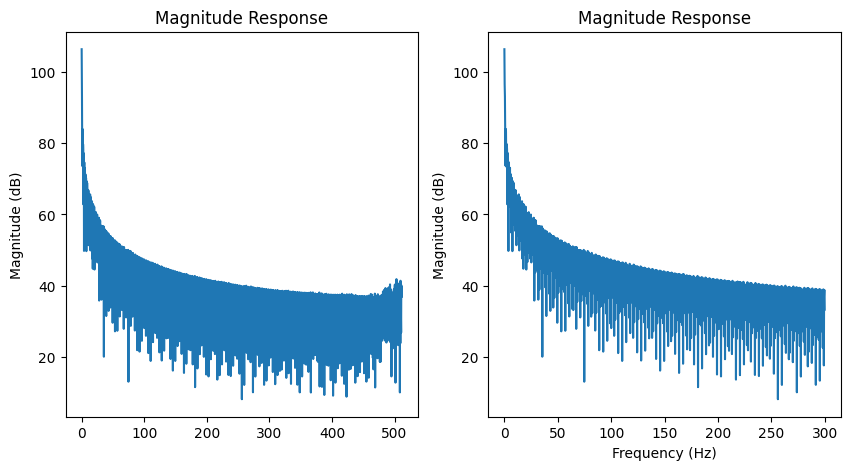

In [28]:
# Analyze the Filtered EKG in the frequency domain
########## Add code here to analyze the Filtered EKG signal in the Frequency domain ##########
# Try creating two plots - one with the full frequency range and one zoomed in on 0-300 Hz #

N = 4*1024
EKG_w_filt = np.fft.fft(filtered_ekg, n=N)
EKG_w_filt = np.fft.fftshift(EKG_w_filt)
EKG_mag_filt = 20*np.log10(np.abs(EKG_w_filt))
EKG_ang_filt = np.angle(EKG_w_filt)

freq_filt = np.fft.fftfreq(len(EKG_w_filt), dt)
freq_filt = np.fft.fftshift(freq_filt)

# 1x2 Plot of Magnitude and Phase
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(freq_filt[len(freq_filt)//2:], EKG_mag_filt[len(freq_filt)//2:])
#ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Magnitude (dB)")
ax1.set_title("Magnitude Response")

ax2.plot(freq_filt[len(freq_filt)//2:(len(freq_filt)//2+300*(N//fs))], EKG_mag_filt[len(freq_filt)//2:(len(freq_filt)//2+300*(N//fs))])
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("Magnitude (dB)")
ax2.set_title("Magnitude Response")

######################################

### 2.3.4 IIR Notch Filter with Harmonics and Lowpass Filter
We are very close to semi-decent results; now we just need to eliminate the high-frequency noise by adding a zero at $-1$ in the pole-zero plot. You may also optionally add another pair of zeros somewhere at higher frequencies (remember the pair will be complex conjugates) to further attenuate higher frequencies. 

ValueError: Improper transfer function. `num` is longer than `den`.

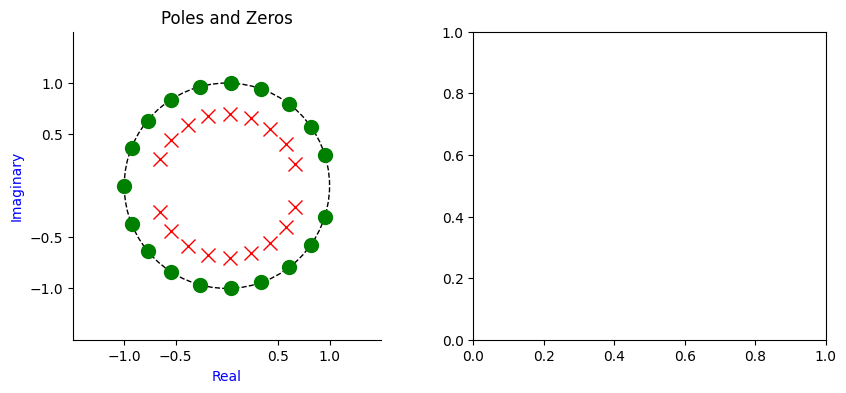

In [29]:
########## Add your definition of the filter coefficients here ##########
zeros_list.append(-1+0j)
zeros = np.array(zeros_list, dtype=np.complex128)
poles = np.array(poles_list, dtype=np.complex128)
k = 1
#########################################################################
utils.freq_analysis(poles, zeros, k, fs, n=1024)

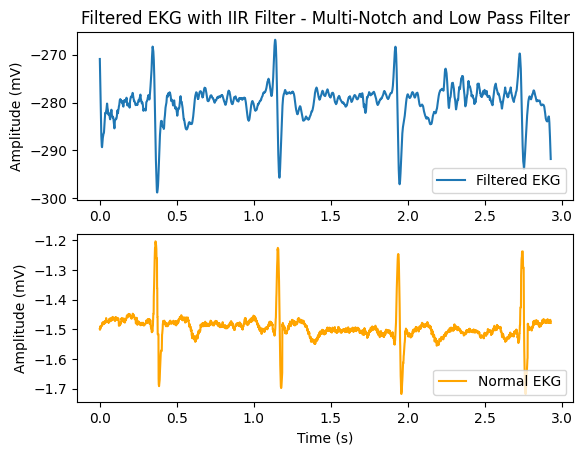

In [30]:
b, a = signal.zpk2tf(zeros, poles, k)
filtered_ekg = signal.filtfilt(b, a, x=noisy_ekg)
filtered_ekg = [np.real(x) for x in filtered_ekg]

t = np.arange(0, M//3*dt, dt)
# 2 plots stacked 
plt.figure()
plt.subplot(2,1,1)
plt.plot(t, filtered_ekg[0:M//3], label="Filtered EKG")
plt.title("Filtered EKG with IIR Filter - Multi-Notch and Low Pass Filter")
plt.ylabel("Amplitude (mV)")
plt.legend(loc='lower right')

plt.subplot(2,1,2)
plt.plot(t, normal_ekg[0:M//3], color="orange", label="Normal EKG")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.legend(loc='lower right')

Text(0.5, 1.0, 'Magnitude Response')

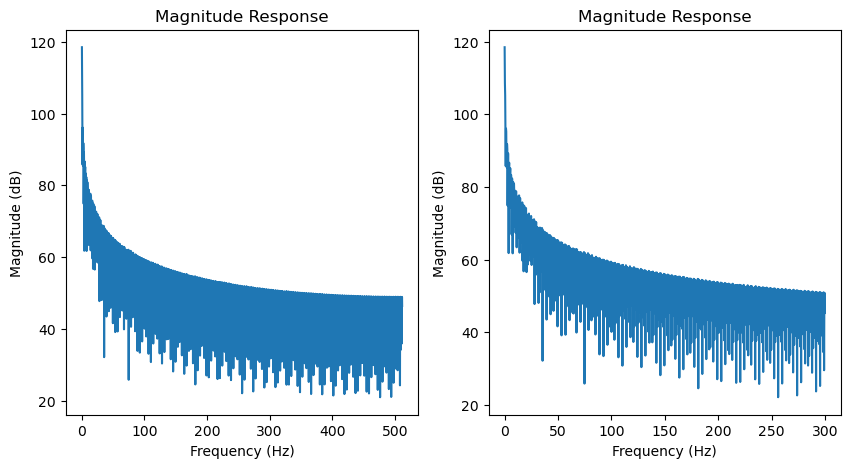

In [27]:
# Analyze the Filtered EKG in the frequency domain
########## Add code here to analyze the Filtered EKG signal in the Frequency domain ##########
# Try creating two plots - one with the full frequency range and one zoomed in on 0-300 Hz #
N = 4*1024
EKG_w_filt = np.fft.fft(filtered_ekg, n=N)
EKG_w_filt = np.fft.fftshift(EKG_w_filt)
EKG_mag_filt = 20*np.log10(np.abs(EKG_w_filt))
EKG_ang_filt = np.angle(EKG_w_filt)

freq_filt = np.fft.fftfreq(len(EKG_w_filt), dt)
freq_filt = np.fft.fftshift(freq_filt)

# 1x2 Plot of Magnitude and Phase
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(freq_filt[len(freq_filt)//2:], EKG_mag_filt[len(freq_filt)//2:])
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Magnitude (dB)")
ax1.set_title("Magnitude Response")

ax2.plot(freq_filt[len(freq_filt)//2:(len(freq_filt)//2+300*(N//fs))], EKG_mag_filt[len(freq_filt)//2:(len(freq_filt)//2+300*(N//fs))])
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("Magnitude (dB)")
ax2.set_title("Magnitude Response")

######################################

### 2.3.5 Final Result

The final task is to tell the heart-rate from the filtered EKG. Zoom-in on the magnitude frequency spectrum of the filtered EKG between 0-3 Hz. To make a better estimate of the heart-rate, we will observe the data over a longer duration ~90 seconds.

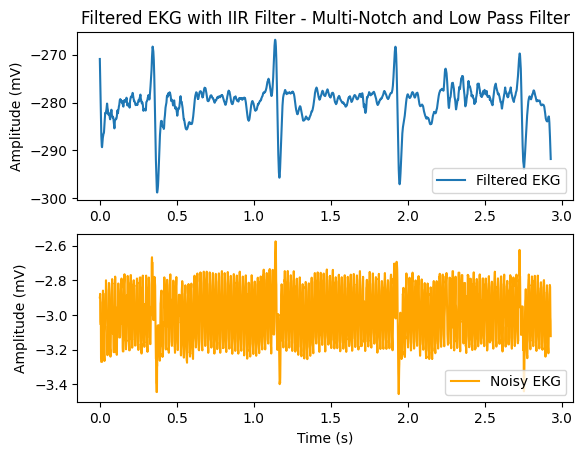

In [31]:
b, a = signal.zpk2tf(zeros, poles, k)
filtered_ekg = signal.filtfilt(b, a, x=noisy_ekg)
filtered_ekg = [np.real(x) for x in filtered_ekg]

t = np.arange(0, M//3*dt, dt)
# 2 plots stacked 
plt.figure()
plt.subplot(2,1,1)
plt.plot(t, filtered_ekg[0:M//3], label="Filtered EKG")
plt.title("Filtered EKG with IIR Filter - Multi-Notch and Low Pass Filter")
plt.ylabel("Amplitude (mV)")
plt.legend(loc='lower right')

plt.subplot(2,1,2)
plt.plot(t, noisy_ekg[0:M//3], color="orange", label="Noisy EKG")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.legend(loc='lower right')

Text(0.5, 1.0, 'Phase Response')

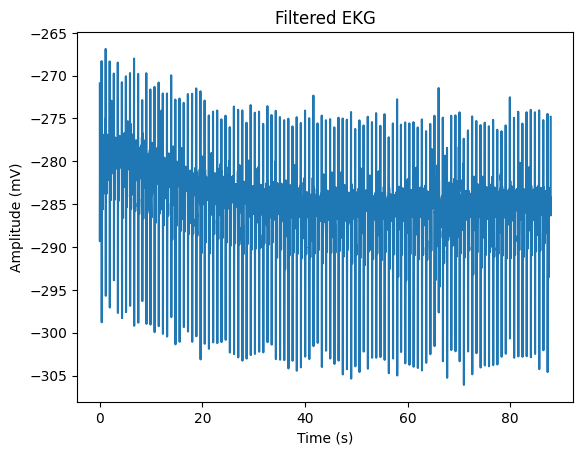

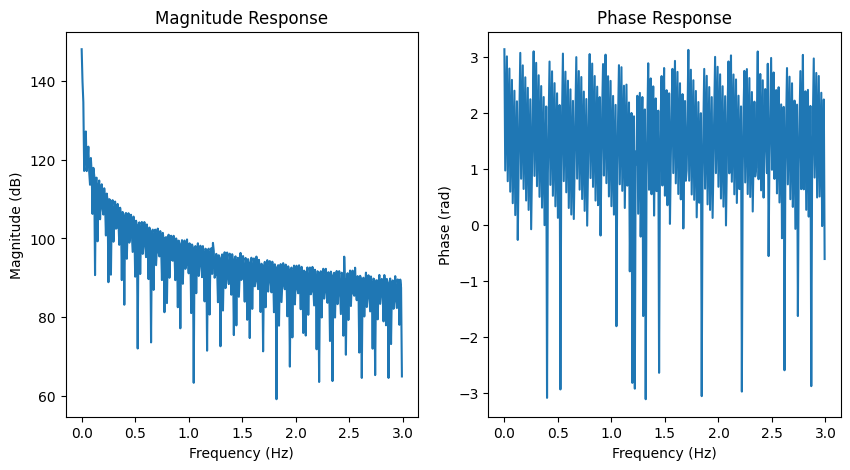

In [32]:
fs = 1024 # Hz # 1 EKG sample every 1/fs seconds
dt = 1/fs
M = 90000 # Number of samples
t = np.arange(0, M*dt, dt)
noisy_ekg = np.load("./data/noisy_ekg.npy", allow_pickle=True)[0:M]
b, a = signal.zpk2tf(zeros, poles, k)
filtered_ekg = signal.filtfilt(b, a, x=noisy_ekg)
filtered_ekg = [np.real(x) for x in filtered_ekg]
plt.plot(t, filtered_ekg)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.title("Filtered EKG")


# Analyze the Filtered EKG between 0-3Hz in the frequency domain
########## Add code here to analyze the Filtered EKG signal in the Frequency domain ##########
from math import ceil, log

N = pow(2, ceil(log(M, 2)))
EKG_w_filt = np.fft.fft(filtered_ekg, n=N)
EKG_w_filt = np.fft.fftshift(EKG_w_filt)
EKG_mag_filt = 20*np.log10(np.abs(EKG_w_filt))
EKG_ang_filt = np.angle(EKG_w_filt)

freq_filt = np.fft.fftfreq(len(EKG_w_filt), dt)
freq_filt = np.fft.fftshift(freq_filt)

# 1x2 Plot of Magnitude and Phase
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(freq_filt[len(freq_filt)//2:(len(freq_filt)//2+3*(N//fs))], EKG_mag_filt[len(freq_filt)//2:(len(freq_filt)//2+3*(N//fs))])
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Magnitude (dB)")
ax1.set_title("Magnitude Response")
ax2.plot(freq_filt[len(freq_filt)//2:(len(freq_filt)//2+3*(N//fs))], EKG_ang_filt[len(freq_filt)//2:(len(freq_filt)//2+3*(N//fs))])
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("Phase (rad)")
ax2.set_title("Phase Response")
######################################

<b>*Question 9: What is your estimate of the heart-rate in beat-per-minute (BPM), based on the magnitude spectrum?*</b><br>
Answer: [There is a peak at around 1.2Hz. Thus BPM = 1.2Hz * 60sec = 72.]

That's the end of HW7! Designing filters using simple intuition from Pole-Zero Plots and Frequency domain analysis can be very effective. If you take future courses, you will learn more of the nuances of these filters as well as new methods for filtering signals in more efficient and better ways! 